In [1]:
# from jupyterthemes import get_themes
# !jt -t solarizedd -T -N -kl

'''
RUN THIS IN SAGEMATH9.2 environment. A new conda environment is recommanded!! 
'''

'\nRUN THIS IN SAGEMATH9.2 environment. A new conda environment is recommanded!! \n'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sage.combinat.symmetric_group_representations import SymmetricGroupRepresentation
from sage.combinat.permutation import *
import scipy
import netket as nk
import jax
import jax.numpy as jnp
import netket.nn as nknn
from jax import grad, jit, vmap, vjp 
from jax import random
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, eigvalsh
from sympy.combinatorics import Permutation as Perm
from sympy.interactive import init_printing
import json
import networkx as nx 
from FourierFilters import FourierFilters
from sgd import CSnGradient
from jax import random 

#### This module consited of building and training module from unfrustrated J2 =0 lattice diagram working in the partition = [n/2, n/2],  the subspace for the true ground state in the unfrusrated region by the Marshall Sign-rule




#  CSn Fourier Filters & Finding the Ground States of J1-J2 Heisenberg 

#### Need the SageMath9.2 environment installed via a conda env or a virtual env... recommend a new conda env 

#### Use JAX, NetKet, Torch packages for notebook

## CSn FourierFilter Class 

### Example (J1-J2) on the 3-square lattice 

[(1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (3, 4), (4, 8), (5, 6), (6, 7), (7, 8)]


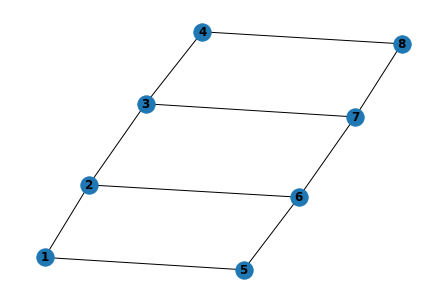

In [3]:

graph = nx.generators.lattice.grid_2d_graph(2,4)
graph = nx.relabel.convert_node_labels_to_integers(graph, first_label=1)
# obs = []
# coeffs = []
# for edge in graph.edges():
#     print(edge)
#     coeffs.extend([1.0, 1.0, 1.0])
#     obs.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
#                         qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
#                         qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
# hamiltonian_heisenberg = qml.Hamiltonian(coeffs, obs)


nx.draw(graph, with_labels=True, font_weight='bold')
print(graph.edges())

In [4]:
J = [1, 0] # unfrustrated system for now 
# lattice2 = [[(1,2), (2,3), (3,4),(4,5), (5,6),(1,6), (2,5)],[(1,5), (2,6), (2,4), (3,5),(1,3), (4,6)]]
lattice3 = [graph.edges(), 
            [(2,5), (5,7), (1,6), (6,8), (3,6), (2,7), (7, 4), (3,8), (2,4), (1,3)]]
partit = [int(4),int(4)]
Nsites = int( 8) 


CsnFourier = CSnGradient(J= J, lattice = lattice3, Nsites=Nsites, 
                    partit=partit,p=int(3), num_samples =int(20), max_iter = int(501))


Ham_rep = CsnFourier.Ham_rep()

# print(CsnFilters.rep_mat_H)
E_gs, V_gs = eigh(Ham_rep.astype('float64'), subset_by_index=[0,1])
V_gs = V_gs[:,0]
E_gs = E_gs[0]
V_gs = jnp.asarray(V_gs)
print('True Ground state Energy via ED: {} '.format( E_gs))
print('True Ground State wavefuncion in Sn irrep basis: {}'.format(V_gs))

print('Irrep Dims for {}: --- {}'.format(partit, CsnFourier.dim))

# print(Ham_rep)

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


True Ground state Energy via ED: -4.29306645665707 
True Ground State wavefuncion in Sn irrep basis: [ 0.15237393  0.0651285  -0.00648768  0.28327447 -0.00648768  0.25822267
 -0.31443686  0.14116936 -0.17426199  0.28327447 -0.31443686  0.13560986
 -0.17426199  0.66969703]
Irrep Dims for [4, 4]: --- 14


In [4]:
'''
Compare with the Exact diagonalization method in the computational basis 
Note that we need to divide by four due to different convention used for S_i . S_j
'''


# Define a 1d chain
dim_site = [2,4]
g = nk.graph.Grid(extent= dim_site, pbc=False)
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
hi = nk.hilbert.Spin(s=float(0.5), total_sz=int(0), N=g.n_nodes)

# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy from computational basis =',exact_gs_energy/float(4)) 

print('True Ground state Energy via ED in Sn irrep with the parition {}: {} '.format(partit, E_gs))

# Just in case you can't do this calculation, here is the result
# exact_gs_energy = -39.14752260706246

The exact ground-state energy from computational basis = -4.293066456657067
True Ground state Energy via ED in Sn irrep with the parition [4, 4]: -4.29306645665707 


Objective is to minialize the expectation $\langle \Psi(\vec{\theta})| \widehat{H}|\Psi(\vec{\theta})\rangle $ 

Three criterions needed: (1) Energy (2) Sign structure (sign of the coefficients) (3) Spin-Spin correlation  $S^{2}(\vec{q})=\frac{1}{n(n+2)} \sum_{i, j}\left\langle\hat{\boldsymbol{S}}_{i} \cdot \hat{\boldsymbol{S}}_{j}\right\rangle e^{i \vec{q} \cdot\left(\vec{r}_{i}-\vec{r}_{j}\right)}$

### Step 1:  To calculate the Mixing hamiltonian $H_M = \sum_{k \leq \ell} \beta_{k, \ell} X_k X_{\ell}$ and its Sn irrep form under partit = [4,4]

In [5]:
'''
use SageMath9.2 environment. Alert may not be complient with the JAX 
Here we aim to get the YJMs X_1X_8 and X_3X_4
'''

X1X8 = CsnFourier.get_YJMs(1,8, opt = 'exact')
X3X4 = CsnFourier.get_YJMs(3,4, opt = 'exact')

print('YJMs with X1X8 is {}'.format(X1X8))
print('-----------------')
print('YJMs with X3X4 is {}'.format(X3X4))




YJMs with X1X8 is [(1,8), (2,8), (3,8), (4,8), (5,8), (6,8), (7,8)]
-----------------
YJMs with X3X4 is [(1,4,3), (1,4)(2,3), (2,4,3)]


In [ ]:
'''
NOw we store the H_M and H_p into two seperate csv files 
(I will update a google colab very soon so that no SageMath is needed )
'''

import pandas as pd

Num = CsnFourier.Nsites* (CsnFourier.Nsites + 1) /2
# Hm_matrix = np.zeros((Num, CsnFourier.dim  ))
Hm_matrix = dict()
for i in range(1, CsnFourier.Nsites+1): 
    if i ==CsnFourier.Nsites: 
        YJM_rep = CsnFourier.get_YJMs(i, i)
        Hm_matrix[(i,i)] = np.diag(YJM_rep)
    for j in range(i, CsnFourier.Nsites+1):
        YJM_rep = CsnFourier.get_YJMs(i, j)
        Hm_matrix[(i,j)] = np.diag(YJM_rep).astype('float64')

print(Hm_matrix)
    

In [ ]:
print(Hm_matrix.keys())
df = pd.DataFrame.from_dict(Hm_matrix)
df
df.to_csv('../data/YJM_S0_8_s.csv')

'''
file read YJM at total spin S=0 irrep with sites number = 8 for the square lattice
'''

In [ ]:
'''
We also write heisenberg into csv 
'''

Heisenberg = CsnFourier.Ham_rep()

df2 = pd.DataFrame(Heisenberg.astype('float64'))
df2.to_csv('../data/Heisenberg_S0_8_s.csv')

In [6]:
'''
Compute the exp(-i H_M) in this Sn irrep partition = [4,4] 
(time parameters implied in the coupling strength)
'''
YJMparams, Hparams = CsnFourier.random_params2(scale=float(1e0))
# YJMparams = Params[0]
YJMparams_p1 = YJMparams.at[:,:,int(0)].get()
YJM_ansazte = CsnFourier.YJM_Conv2d(YJMparams_p1)

In [8]:
print('YJM_ansazte per layer (must be stricly diagonal):   {}'.format(jnp.diag(YJM_ansazte)))
print('-----------------------------------------------')
print('The norm of YJM_ansazte per layer (must be equal to one): {}'.format(jnp.linalg.norm(YJM_ansazte)))

YJM_ansazte per layer (must be stricly diagonal):   [-0.11472269+0.24138615j -0.1249263 +0.23626678j  0.09676384-0.24912915j
  0.26693857+0.01312905j  0.0301001 +0.26556083j  0.05131156+0.26228934j
 -0.19495205+0.18281759j  0.03442245-0.26503522j -0.07628553+0.25614271j
 -0.26420522-0.04030104j  0.02773434-0.26581832j  0.26413619-0.04075099j
  0.01672274-0.26673755j -0.05908448+0.26064841j]
-----------------------------------------------
The norm of YJM_ansazte per layer (must be equal to one): 0.9999999999999999


In [14]:
'''
Compute the time evolution oeperator exp(-it H)
'''
# Hparams = Params[1]
Hparams_p1 = Hparams.at[int(0)].get()

Heisenberg = CsnFourier.Ham_rep()
Evolution_conv = CsnFourier.Heis_Conv2d(Hparams_p1, Heisenberg)

In [13]:
print('The norm of YJM_ansazte per layer (must be equal to one): {}'.format(
    jnp.linalg.norm(Evolution_conv)))

The norm of YJM_ansazte per layer (must be equal to one): 0.9999999999999999


### Step 2: Build the QAOA ansatze: $U(\vec{\theta}) = exp(-iH_M) exp(-iH) \cdots exp(-i \sum_{k \leq \ell} \beta_{k, \ell} X_k X_{\ell}) exp(-iH)$ with random parameters in Sn irrep with partition $\lambda=[4,4]$

In [15]:
'''
In this class we have initilized p =3 So we can compute the entire ansatze by calling the following 
'''
CSnQAOA = CsnFourier.CSn_Ansazte(YJMparams, Hparams)

In [18]:
print('Dims of CSnQAOA Ansatze {}'.format(CSnQAOA.shape))
print('2-norms of CSnQAOA Ansatze {}'.format(jnp.linalg.norm(CSnQAOA, ord =int(2))))

Dims of CSnQAOA Ansatze (14, 14)
2-norms of CSnQAOA Ansatze 1.0


### Step 3: Sample (randomly) basis vectors and compute triial wavefunction: $| \Psi(\vec{\theta}) \rangle = \sum_i U(\vec{\theta}) | v_{T_i}\rangle$ and we take the real part by $\widetilde{\Psi} = \Psi^* + \Psi $

In [19]:
'''
We randomly sample basis states; 
later we might add more sophisticated method such as gradient based sampling
'''



trial_state = CsnFourier.CSn_VStates(YJMparams, Hparams)
# trial_state = CsnFourier.CSn_VStates(YJMparams, Hparams)


In [20]:
'''
Note that our state is strictly real-valued since we DO NOT add complex number 
'''
print(trial_state)
print('---------------')
print('norm of the trial state: {}'.format(jnp.linalg.norm(trial_state)))

[ 0.43043681  0.01378485 -0.44806053  0.02811659  0.3392206   0.16849223
  0.23487377 -0.40954731  0.32795198  0.3317051   0.09716886  0.13673377
  0.02444249 -0.01772832]
---------------
norm of the trial state: 1.0


In [23]:
'''
let's see the expectation value for this randomly chosen trial state 
'''
Heisenberg = jnp.asarray(Heisenberg.astype('float64'))
T_gs = jnp.matmul(jnp.matmul(jnp.conjugate(trial_state), Heisenberg), trial_state)
print('Trial state expectation value: {}'.format(T_gs))
print('------------------------------------')
print('the ground state energy is: {}'.format(E_gs))


Trial state expectation value: -0.5028132023950972
------------------------------------
the ground state energy is: -4.29306645665707


### Step 4:  Optimize wrt. $\vec{\theta}$ using either (1) SGD (2) Nadam (3) Natural gradient (SR) (still Working on)

#### Use the Nadam with JAX auto-diff and using the energy function: $E[\widetilde{\Psi}] = \frac{\langle \widetilde{\Psi}| H | \widetilde{\Psi} \rangle }{\langle \widetilde{\Psi}|\widetilde{\Psi} \rangle}$ with $\widetilde{\Psi} = \Psi^* + \Psi $

In [5]:
'''
Using the standard decay parameters from Pytorch. 
'''

J = CsnFourier.Expect_braket
opt_YJM, opt_H ,opt_energy_list= CsnFourier.CSn_nadam(J)

updated gradient squared: (8, 8, 3)---(3,)
updated bia correction have the shape: (8, 8, 3)--(3,)
updated YJMparams, Hparams have the shape: (8, 8, 3), (3,)
energy expectation at iteration 0: --- (-1.8909639209105067)
updated gradient squared: (8, 8, 3)---(3,)
updated bia correction have the shape: (8, 8, 3)--(3,)
updated YJMparams, Hparams have the shape: (8, 8, 3), (3,)
energy expectation at iteration 50: --- (-4.054433930102302)
updated gradient squared: (8, 8, 3)---(3,)
updated bia correction have the shape: (8, 8, 3)--(3,)
updated YJMparams, Hparams have the shape: (8, 8, 3), (3,)
energy expectation at iteration 100: --- (-4.283732946097666)
updated gradient squared: (8, 8, 3)---(3,)
updated bia correction have the shape: (8, 8, 3)--(3,)
updated YJMparams, Hparams have the shape: (8, 8, 3), (3,)
energy expectation at iteration 150: --- (-4.293046511176966)
updated gradient squared: (8, 8, 3)---(3,)
updated bia correction have the shape: (8, 8, 3)--(3,)
updated YJMparams, Hparams h

In [7]:
O_gs = CsnFourier.Groundstate(opt_YJM, opt_H)
optimized_energy = CsnFourier.Expect_braket_energy(opt_YJM, opt_H)

In [8]:

print('the optimized ground state: {}'.format(O_gs))
print('------------------------------------')
print('Optimized lowest energy: {}'.format(optimized_energy))
print('-------------------------------------')
print('True Ground State wavefuncion in Sn irrep basis: {}'.format(V_gs))
print('-------------------------------------')
print('The overlap between the optimized state and the ground state: {}'.format(jnp.dot(O_gs,
                                                                               V_gs)))
print('The distance between the optimized state and the ground state: {}'.format(jnp.linalg.norm(jnp.subtract(V_gs, O_gs))))



the optimized ground state: [-0.15237393 -0.0651285   0.00648768 -0.28327447  0.00648768 -0.25822267
  0.31443686 -0.14116936  0.17426199 -0.28327447  0.31443686 -0.13560986
  0.17426199 -0.66969703]
------------------------------------
Optimized lowest energy: -4.293066456657069
-------------------------------------
True Ground State wavefuncion in Sn irrep basis: [ 0.15237393  0.0651285  -0.00648768  0.28327447 -0.00648768  0.25822267
 -0.31443686  0.14116936 -0.17426199  0.28327447 -0.31443686  0.13560986
 -0.17426199  0.66969703]
-------------------------------------
The overlap between the optimized state and the ground state: -0.9999999999999996
The distance between the optimized state and the ground state: 1.9999999999999996


[-4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707, -4.29306645665707]


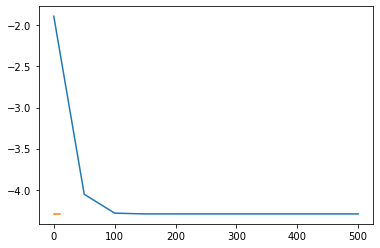

In [20]:
plt.plot([i * 50 for i in range(0,11)], opt_energy_list)
plt.plot([E_gs for i in range(0,11)])
plt.show()

In [ ]:
'''
Do not run these as outdated 
'''

In [ ]:
# trial_GS = CsnFourier.Groundstate()
YJMparams, Hparams = CsnFourier.GD_momentum(Params = optParams)



In [ ]:
# Heisenberg = CsnFourier.Ham_rep()
# Heisenberg = jnp.asarray(Heisenberg, dtype ='float64')
O_gs = CsnFourier.Groundstate(YJMparams, Hparams)
optimized_energy = CsnFourier.Expect_braket_energy(YJMparams, Hparams)


In [ ]:


print('the optimized ground state: {}'.format(O_gs))
print('------------------------------------')
print('Optimized lowest energy: {}'.format(optimized_energy))
print('-------------------------------------')
print('True Ground State wavefuncion in Sn irrep basis: {}'.format(V_gs))
print('-------------------------------------')
print('The overlap between the optimized state and the ground state: {}'.format(jnp.dot(O_gs,
                                                                               V_gs)))



#### Using the Overlap WIth ED Groundstate energy 

In [ ]:
'''
Loss function written to overlap with energy 
'''

YJMparams, Hparams = CsnFourier.GD_momentum(opt='overlap_energy')

In [ ]:
O_gs = CsnFourier.Groundstate(YJMparams, Hparams)
optimized_energy = CsnFourier.Expect_braket_energy(YJMparams, Hparams)


In [ ]:
V_gs = jnp.asarray(V_gs.at[:,int(0)].get())


print('the optimized ground state: {}'.format(O_gs))
print('------------------------------------')
print('Optimized lowest energy: {}'.format(optimized_energy))
print('-------------------------------------')
print('True Ground State wavefuncion in Sn irrep basis: {}'.format(V_gs))
print('-------------------------------------')
print('The overlap between the optimized state and the ground state: {}'.format(jnp.dot(O_gs,
                                                                               V_gs)))



In [ ]:
'''
Loss function wrt. exact diagonal state 
'''
J = CsnFourier.Expect_OverlapS
YJMparams, Hparams = CsnFourier.GD_momentum(opt='overlap_state')


In [ ]:

O_gs = CsnFourier.Groundstate(YJMparams, Hparams)
optimized_energy = CsnFourier.Expect_braket_energy(YJMparams, Hparams)




In [ ]:

optYJM = YJMparams
optH = Hparams
optParams = [optYJM, optH]
print('the optimized ground state: {}'.format(O_gs))
print('------------------------------------')
print('Optimized lowest energy: {}'.format(optimized_energy))
print('-------------------------------------')
print('True Ground State wavefuncion in Sn irrep basis: {}'.format(V_gs))
print('-------------------------------------')
print('The overlap between the optimized state and the ground state: {}'.format(jnp.dot(O_gs,
                                                                               V_gs)))
print('The distance between the optimized state and the ground state: {}'.format(jnp.linalg.norm(jnp.subtract(V_gs, O_gs))))


In [ ]:
J = CsnFourier.Expect_OverlapS
YJMparams, Hparams = CsnFourier.CSn_nadam(J, delta1=float(0.9), 
                                          delta2 = float(0.95))

#### Step4.2 Get the params close to the true ground state 

### Step 5:  Gradient Descent with Custom derivative rules 

In [ ]:
'''
Using Gradient Descent with the moment 
'''

YJMparams, Hparams = CsnFourier.GD_momentum(mode='exact', opt=None)

# Params = CsnFourier.random_params2()
# YJMparams = Params[0]
# Hparams = Params[1]
# trial_states  = CsnFourier.CSn_VStates(YJMparams, Hparams)


In [ ]:
# print(jnp.linalg.norm(trial_states))

# print(np.array([0,1,1,2]).astype('float64'))
# print(np.array([0,1,2,3]).astype('complex128'))

In [ ]:
# best_params = CsnFourier.SGD_momentum()

In [ ]:
# X24_rep = CsnFilters.get_YJMs(1,2)
# # from sympy.combinatorics import Permutation
# # from sympy.interactive import init_printing

# # p = [5,6]
# # q = [4,5]
# # p =Permutation([[4,5]]) * Permutation([[5,6]])
# # print(p.array_form)s

# # S = SymmetricGroup(4)
# # p = S('(2,4)')
# # q = S('(3,4)')
# # print(set(p * q))

# print(X24_rep)
# # print(X24)
# X24rep = jnp.asarray(X24_rep, dtype='float64')
# print(X24rep.at[int(1),int(3)].get())



In [ ]:
# orth = SymmetricGroupRepresentation([3,3],'orthogonal')
# S = SymmetricGroup(6)
# p = S('(1,2)(3,4)')
# S1 = np.array(orth.representation_matrix((1,4,2)))
# S2 = np.array(orth.representation_matrix((1,2, 4)))
# S3 = np.array(orth.representation_matrix(p))

# print(np.add(np.add(S1,S2), S3))


In [ ]:
# def random_params(n, key, scale= float( 1e-2)):
#   w_key, b_key = random.split(key)
#   return jnp.multiply(scale, random.normal(w_key, (n, n))), jnp.multiply( scale,  random.normal(b_key))
# YJMparams, Hparams = random_params(CsnFilters.Nsites, random.PRNGKey(0))
# # jnp.iscomplex(YJMparams)
# # print(YJMparams)
# YJM_conv = CsnFilters.YJM_Conv2d(YJMparams)
# print(YJM_conv.shape)

In [ ]:
# print(jnp.linalg.norm(YJM_conv, ord='fro'))
# print(jnp.diag(YJM_conv))

In [ ]:
# rep_H = CsnFilters.Ham_rep()
# Hesi_conv = CsnFilters.Heis_Conv2d(Hparams, rep_H)
# print(jnp.linalg.norm(Hesi_conv, ord='fro'))


In [ ]:
def random_params(n, p, scale= float( 1e-2)):
    YJMparams = jnp.zeros((n,n,p))
    Hparams = jnp.zeros((p))
    for i in range(p):
        w_key, b_key = random.split(random.PRNGKey(int(i)))
        YJMparams = YJMparams.at[:,:,i].set( jnp.multiply( scale, random.normal(w_key, (n,n))))
        Hparams = Hparams.at[i].set(jnp.multiply(scale, random.normal(b_key)))
    return [YJMparams, Hparams]
    
Parameters= random_params(CsnFilters.Nsites, 3)


In [ ]:
groundstate = CsnFilters.CSn_VStates(10, Parameters[0], Parameters[1])

In [ ]:
print(jnp.linalg.norm(groundstate))
print(groundstate)

In [ ]:
def J(rep_H, YJMparams, Hparams, num_samples= 10):
    groundstate = CsnFilters.CSn_VStates(num_samples, YJMparams, Hparams)
    return jnp.matmul(jnp.conjugate(groundstate), jnp.matmul(rep_H, groundstate))

In [ ]:
rep_H = CsnFilters.Ham_rep()
rep_H = jnp.asarray(rep_H.astype('float64'))
expectation = J(rep_H, Parameters[0], Parameters[1])

In [ ]:
print(expectation)

## Sampling and Optimization 

#### Sampling via the unjusted Langevin Algorithm 

$\theta_{n+1}=\theta_{n}+d t \nabla \log \pi\left(\theta_{n}\right)+\sqrt{2 d t} \xi$
            
            
            
            

In [ ]:
import jax
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('JAX SGD')


class SGD(FourierFilters):
    '''
    Standard SGD method implemented using JAX autodifferentiation megthd

    Unsurpervised method for the minilization of the GS energy for each Sn irrep

    Wirtten in the language environment SAGE9.2, supported SageMath environment

    '''

    def __init__(self, lr = float(0.05), max_iter = int(1e3), gamma = float(0.95)):
        FourierFilters.__init__(self,J=None, lattice=None, Nsites=None, partit=None, p=1)
        self.lr = lr
        self.max_iter = max_iter
        self.gamma = gamma 

    

    def SGD_momentum(self,rep_H, J, Params):

        """Performs linear regression using batch gradient descent + momentum

        Args:
            J: cost function with single Params = [YJMparams, Hparams]
            gamma: Decay parameter for vecloity sum

        Returns:
            params: the weights and bias after performing the optimization
        """

        # Some configurations
        LOG = False


        YJMparams = Params[0]
        Hparams = Params[1]

        # To keep track of velocity parameters
        params_v = {
            'YJM': jnp.zeros(Params[0].shape),
            'H': jnp.zeros(Params[1].shape)
        }

        # Define the gradient function w.r.t w and b
        grad_YJM = jax.jit(jax.grad(J,argnums=int(1)))  # argnums indicates which variable to differentiate with from the parameters list passed to the function
        grad_H = jax.jit(jax.grad(J, argnums=int(2)))

        # Run once to compile JIT (Just In Time). The next uses of grad_W and grad_B will now be fast
        grad_YJM(rep_H, YJMparams, Hparams)
        grad_H(rep_H, YJMparams, Hparams)

        for i in range(self.max_iter):
            # Gradient w.r.t. argumnet index 1 i.e., w
            grad_yjm = grad_YJM(rep_H, YJMparams, Hparams)
            # Gradient w.r.t. argumnet index 2 i.e., b
            grad_h = grad_H(rep_H, JMparams, Hparams)

            # Update velocity
            params_v['YJM'] = jnp.add( jnp.multiply(self.gamma,  params_v['YJM']) , grad_yjm)
            params_v['H'] = jnp.add( jnp.multiply(self.gamma, params_v['H'] ), grad_h)

            # Parameter update
            YJMparams -= jnp.multiply(self.lr, params_v['wv'])
            Hparams -= jnp.multiply(self.lr , params_v['bv'])

            if LOG and i % int(20) == int(0):
                print(J( YJMparams, Hparams))

        return [YJMparams, Hparams]

    # X, X_test, y, y_test, coef = get_data()
    # params = momentum(J, X, y)
    #
    # print("True weights =", coef)
    # print("Calculated weights =", params['w'])
    # print("True bias = 2.0\tCalculated bias = {:.6f}".format(params['b']))
    # print("Test loss: {:.9f}".format(J(X_test, params['w'], params['b'], y_test)))

    
    

In [ ]:
mSCG = SGD()
best_params = mSCG.SGD_momentum(J, rep_H, Parameters)